## Using IRASA together with MNE Python

MNE Python offers a great beginner level interface to start analysing electrophysiological data.
If you are already familiar with MNE Python it is very easy to integrate PyRASA in your existing workflow.
This example notebook shows how to use PyRASA on your raw and epoched data.

In [1]:
import sys
from neurodsp.sim import sim_combined
import numpy as np
import scipy.signal as dsp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('ticks')
sns.set_context('paper')
sys.path.append('../')


import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

import mne
from mne.datasets import sample

from pyrasa.irasa_mne import irasa_raw, irasa_epochs

%matplotlib inline

We start by loading some MNE example data. More information about the dataset can be obtained from here TODO: insert link

In [2]:

data_path = sample.data_path()
subjects_dir = data_path / "subjects"
subject = "sample"

meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"


raw = mne.io.read_raw_fif(raw_fname)
picks = mne.pick_types(raw.info, meg='mag', eeg=False, 
                       stim=False, eog=False, exclude="bads")
raw.pick(picks)

Opening raw data file /Users/fabian.schmidt/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,102 Magnetometers
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


We start by using the irasa_raw function. This function can be directly applied to your mne raw data object and will return a `AperiodicSpectrumArray` and a `PeriodicSpectrumArray` class. Both of the returned data classes are children from the MNE SpectrumArray class and allow you to use both the internal mne based plotting and analysis methods, as well as some specific methods to further investigate your aperiodic and periodic data.

A strength of IRASA is that the user needs to specify relatively few parameters to seperate periodic from aperiodic activity. Actually its really only one parameter that is the hset, which specifies the up- and downsampling factors IRASA uses.

However, misspecifications of hset can have can have severe consequences (see introduction to IRASA) for specifics regarding the algorithm and how things can go wrong. But dont worry the IRASA MNE functions are defined in a way that will throw an error in case you accidently fit models that are error prone and will tell you how you should specify your parameters such that everything should run smoothely.

Try changing the input to "band=(0.25, 100)" and see what happens :)

In [3]:
aperiodic_mne, periodic_mne = irasa_raw(raw, band=(.25, 50), 
                                duration=2, 
                                hset_info=(1.,2.,.05),
                                as_array=False)

Now we can start investigating the returned `AperiodicSpectrumArray` and `PeriodicSpectrumArray` classes. 

You can use the basic plotting functions to compare the irasa'ed results to the classic power spectrum.

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=False).


/var/folders/6x/k2wvgw51691cj5qd77pzcrfw0000gn/T/ipykernel_15944/3776130424.py:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd(method='welch', n_per_seg=nperseg, n_overlap=nperseg//2, fmin=0.25, fmax=50).plot(axes=axes[0])
/Users/fabian.schmidt/miniforge3/envs/pyrasa/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/6x/k2wvgw51691cj5qd77pzcrfw0000gn/T/ipykernel_15944/3776130424.py:5: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  aperiodic_mne.plot(axes=axes[1])
/Users/fabian.schmidt/git/pyrasa/pyrasa/irasa_mne/mne_objs.py:41: UserWarning: Zero value in PSD for channels MEG 0111, MEG 0121, MEG 0131, MEG 0141, MEG 0211, MEG 0221, MEG 0231, MEG 0241, MEG 0311, MEG 0321, MEG 0331, MEG 0341, MEG 0411,

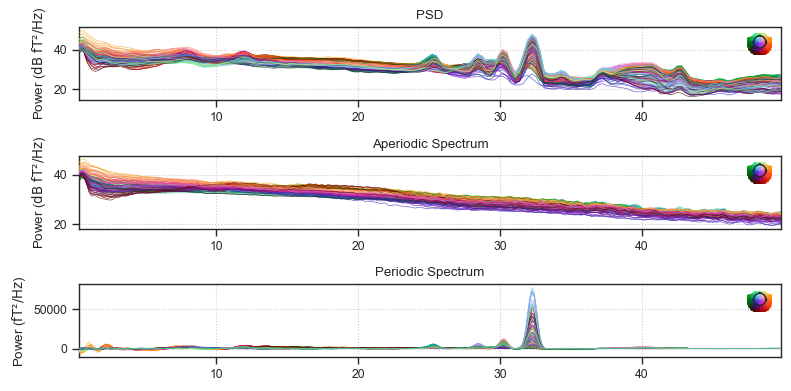

In [4]:
f, axes = plt.subplots(nrows=3, figsize=(8, 4))

nperseg = int(raw.info['sfreq']*2)
raw.compute_psd(method='welch', n_per_seg=nperseg, n_overlap=nperseg//2, fmin=0.25, fmax=50).plot(axes=axes[0])
aperiodic_mne.plot(axes=axes[1])
periodic_mne.plot(axes=axes[2])

axes[0].set_title('PSD')
axes[1].set_title('Aperiodic Spectrum')
axes[2].set_title('Periodic Spectrum')

f.tight_layout()

Now lets further investigate the returned spectra, by doing some slope fitting on the `AperiodicSpectrumArray` or trying to detect some putative oscillations in the `PeriodicSpectrumArray`. Generally speaking this is not necessary as you could just stop at this point and simply compare either periodic or aperiodic spectra directly across different subjects or experimental conditions, but sometimes we have specific expectations/assumptions about certain parameters of interest in a power spectrum and its therefore a good idea to parametrize our spectra early on.

Lets start with the `AperiodicSpectrumArray`: 
Here we can use the `get_slopes` method to extract two pandas dataframes. One containing the aperiodic parameters extracted from the data and another containing information about how well these parameters explained variance in the data.

The `get_slopes` method allows you to specify different methods to model your aperiodic spectrum. You can choose between a `fixed` and a `knee` mode similarly to specparam. However, it is worth noting that the `knee` fitting in PyRASA is slightly different as it allows you to fit two slopes and a knee.

You can also limit the range of your slope fit to a specific frequency range of interest (e.g. 30-40Hz). However, be aware that large freqeuency ranges are usually preferable, as decreasing your frequency range of interest too much usually results in a worse model fit (see Ameen et al. 2024). However, in some cases this decision might be viable e.g. understanding differences in E/I ratios (see Gao et al. 2017).

Lets start by comparing a `fixed` to a `knee` model fit. 


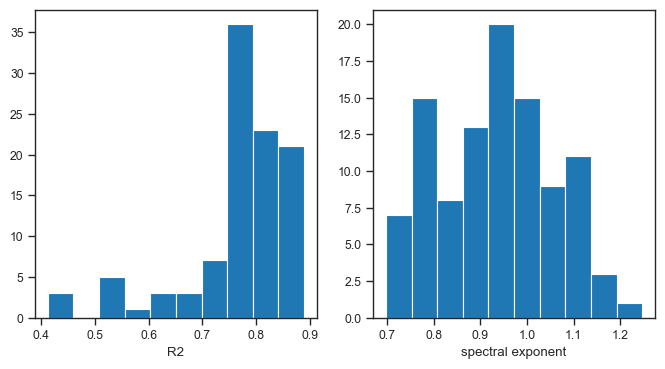

In [5]:
df_ap_f, df_gof_f = aperiodic_mne.get_slopes(fit_func='fixed')

f, axes = plt.subplots(ncols=2, figsize=(8,4))

axes[0].set_xlabel('R2')
axes[1].set_xlabel('spectral exponent')
axes[0].hist(df_gof_f['r_squared']);
axes[1].hist(df_ap_f['Exponent']);

In [6]:
df_ap_k, df_gof_k = aperiodic_mne.get_slopes(fit_func='knee');

[8.12443614e-27 3.15477586e+01 6.60501978e-01 6.60501978e-01]
[1.22511558e-26 2.39929426e+01 7.25164328e-01 7.25164328e-01]
[8.60539845e-27 1.91811615e+01 6.59632630e-01 6.59632630e-01]
[5.75510269e-27 2.78690810e+01 6.31631731e-01 6.31631731e-01]
[9.75770451e-27 1.79125741e+01 6.85216957e-01 6.85216957e-01]
[9.19499733e-27 2.30300860e+01 6.73513998e-01 6.73513998e-01]
[8.72679060e-27 2.41626969e+01 7.11190032e-01 7.11190032e-01]
[7.75122765e-27 1.98895545e+01 6.92904368e-01 6.92904368e-01]
[1.09711537e-26 2.73887527e+01 7.02235342e-01 7.02235342e-01]
[7.99743072e-27 2.19195720e+01 6.23804584e-01 6.23804584e-01]
[7.35509746e-27 2.43851186e+01 6.30090479e-01 6.30090479e-01]
[1.13200979e-26 2.01004252e+01 6.95348208e-01 6.95348208e-01]
[9.15673209e-27 2.63852280e+01 6.90276489e-01 6.90276489e-01]
[9.47657964e-27 3.06353649e+01 7.21776480e-01 7.21776480e-01]


/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in power
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in multiply
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in power
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in multiply
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in power
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in multiply
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))


[9.85400409e-27 3.34737416e+01 7.58494948e-01 7.58494948e-01]
[9.77133344e-27 2.75317147e+01 7.30301403e-01 7.30301403e-01]
[1.25165265e-26 3.93334213e+01 7.45685327e-01 7.45685327e-01]
[1.24451737e-26 4.31572222e+01 7.89523954e-01 7.89523954e-01]
[8.86896974e-27 3.66155730e+01 7.20374650e-01 7.20374650e-01]
[8.08888306e-27 2.79883934e+01 6.40242114e-01 6.40242114e-01]
[7.63839441e-27 3.37002767e+01 6.84652902e-01 6.84652902e-01]
[8.90530345e-27 3.14448898e+01 6.83403936e-01 6.83403936e-01]
[1.05408713e-26 2.95677188e+01 7.06242857e-01 7.06242857e-01]
[8.16832118e-27 3.06272921e+01 6.78182642e-01 6.78182642e-01]
[1.13742080e-26 4.11686238e+01 7.88694654e-01 7.88694654e-01]
[1.02512052e-26 3.66091530e+01 7.46664420e-01 7.46664420e-01]
[1.05397814e-26 4.85725796e+01 8.23780144e-01 8.23780144e-01]
[1.06162319e-26 4.65654084e+01 8.19691559e-01 8.19691559e-01]
[1.10573499e-26 4.80724607e+01 8.07596475e-01 8.07596475e-01]
[8.72432495e-27 3.64386698e+01 7.26496536e-01 7.26496536e-01]
[1.21244

/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in power
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in multiply
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in power
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in multiply
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in power
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyrasa/pyrasa/utils/aperiodic_utils.py:27: RuntimeWarning: overflow encountered in multiply
  y_hat = b0 - np.log10(x**b1 * (k + x**b2))
/Users/fabian.schmidt/git/pyras

[1.09508914e-26 2.60191390e+01 7.32874364e-01 7.32874364e-01]
[1.66510482e-26 2.33264379e+01 7.90475373e-01 7.90475373e-01]
[1.50155952e-26 2.41933001e+01 7.91762981e-01 7.91762981e-01]
[1.29121604e-26 2.78980988e+01 7.77471364e-01 7.77471364e-01]
[2.94425935e-26 2.23805633e+01 9.18982349e-01 9.18982349e-01]
[2.12218964e-26 3.03410894e+01 8.39925590e-01 8.39925590e-01]
[1.32142057e-26 3.45729638e+01 7.91192404e-01 7.91192404e-01]
[2.08875440e-26 2.30847621e+01 8.52393044e-01 8.52393044e-01]
[6.31527460e-27 1.93668712e+01 6.52812626e-01 6.52812626e-01]
[7.26264508e-27 2.12089373e+01 6.86904942e-01 6.86904942e-01]
[5.92250223e-27 3.52581253e+01 6.70966411e-01 6.70966411e-01]
[5.18794984e-27 2.62693541e+01 6.15541892e-01 6.15541892e-01]
[7.50023336e-27 2.14291064e+01 7.15852048e-01 7.15852048e-01]
[1.04072000e-26 3.15732684e+01 8.19816157e-01 8.19816157e-01]
[8.04460787e-27 3.17819578e+01 7.77867019e-01 7.77867019e-01]
[8.92653053e-27 2.76572530e+01 7.69302716e-01 7.69302716e-01]
[6.66751

In [20]:

def num_zeros(decimal):
    return np.inf if decimal == 0 else -np.floor(np.log10(abs(decimal))) - 1

new_d = aperiodic_mne.get_data()
num_zeros(10.01)


-2.0

In [17]:
from pyrasa.utils.aperiodic_utils import compute_slope

new_d = aperiodic_mne.get_data()
new_d = new_d * 10**num_zeros(new_d.min())

df_ap_k, df_gof_k = compute_slope(new_d, aperiodic_mne.freqs, fit_func='fixed')

#df_ap_k, df_gof_k = aperiodic_mne.get_slopes(fit_func='knee')

dir(aperiodic_mne)

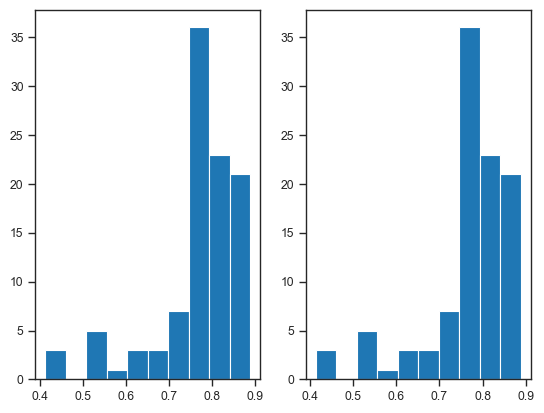

In [18]:
f, ax = plt.subplots(ncols=2)
ax[0].hist(df_gof_k['r_squared']);
ax[1].hist(df_gof_f['r_squared']);

(array([ 8.,  9., 17., 18., 12.,  9., 14., 10.,  4.,  1.]),
 array([ 9.1535972 , 10.56198061, 11.97036402, 13.37874743, 14.78713084,
        16.19551425, 17.60389766, 19.01228107, 20.42066448, 21.82904789,
        23.2374313 ]),
 <BarContainer object of 10 artists>)

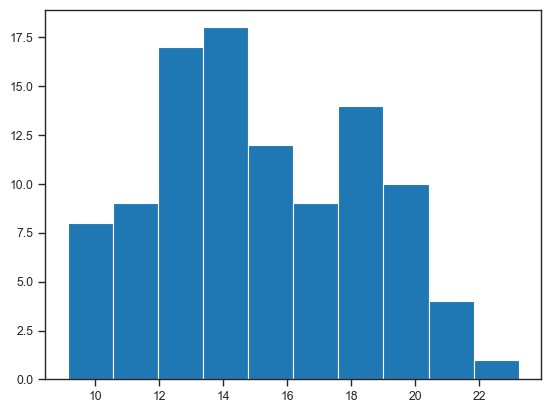

In [11]:
plt.hist(df_ap_k['Knee Frequency (Hz)'])

In [12]:
df_gof_k

,mse,r_squared,fit_type,ch_name
0,0.004602,0.972533,knee,0
0,0.001400,0.991720,knee,1
0,0.001346,0.991578,knee,2
0,0.013917,0.921873,knee,3
0,0.001664,0.990863,knee,4
...,...,...,...,...
0,0.018814,0.895635,knee,97
0,0.001181,0.995211,knee,98
0,0.002794,0.987698,knee,99
0,0.003716,0.981201,knee,100


In [13]:
df_gof_f['r_squared']

,mse,r_squared,fit_type,ch_name
0,0.065741,0.607643,fixed,MEG 0111
0,0.023835,0.859016,fixed,MEG 0121
0,0.023397,0.853570,fixed,MEG 0131
0,0.080934,0.545639,fixed,MEG 0141
0,0.024284,0.866659,fixed,MEG 0211
...,...,...,...,...
0,0.084211,0.532865,fixed,MEG 2541
0,0.036947,0.850222,fixed,MEG 2611
0,0.059782,0.736787,fixed,MEG 2621
0,0.058916,0.701971,fixed,MEG 2631
